In [1]:
"""
    File containing further exploration of the single images data set beyond that done in SingleImages.ipynb
    
    Note: this file uses the pickle files saved in SingleImages.ipynb and hence that needs to be run first.
"""

'\n    File containing further exploration of the single images data set beyond that done in SingleImages.ipynb\n    \n    Note: this file uses the pickle files saved in SingleImages.ipynb and hence that needs to be run first.\n'

In [2]:
### import the required libraries

import numpy as np
import scipy.ndimage as ndimage
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
import pylab as P
import skimage
from sklearn.cross_validation import train_test_split as ttsplit
import cPickle as pickle

In [16]:

## seed the library so we get consistent results each time
tf.set_random_seed(1234)


In [3]:
# helper function to read a pickle file
# TODO: move this to helpers file
def read_pickle_file(f_name):
    f = open(f_name, 'r')
    return pickle.load(f)



In [4]:
## the data dir is at the same level as the src dir in the repo
print os.getcwd()
data_dir = os.path.join(os.path.split(os.getcwd())[0], 'data')
print data_dir

def get_data_path(f_name):
    return os.path.join(data_dir, f_name)

/home/ag/projects/ml_nanodegree/repo/capstone/src
/home/ag/projects/ml_nanodegree/repo/capstone/data


In [5]:
## read all the files off the disk 

file_list = [
    'train_single_data.pkl',
    'train_single_labels.pkl',
    'valid_single_data.pkl',
    'valid_single_labels.pkl',
    'test_single_data.pkl',
    'test_single_labels.pkl',
]


train_images, train_labels, valid_images, valid_labels, test_images, test_labels  = \
    [read_pickle_file(get_data_path(f_name)) for f_name in file_list]


In [75]:
## make sure that the labels are what we think they are
label_set = set(train_labels)
assert(len(label_set) == 10)
num_labels = len(label_set)
labels = range(10)
assert(len(label_set.difference(set(labels))) == 0)

In [76]:
## check the frequency of the labels in the various sets and plot it
## we should have done this at the outset, damnit!
def plot_label_data(x,y, name, x_label, y_label, width=1./3, color='blue'):
    plt.bar(x, y, width = width, color = color)
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    


def plot_label_distribution(label_data, name):
    
    sizes = np.array([len(np.where(label_data==l)[0]) for l in labels], dtype=np.float32)
    print sizes/sum(sizes)
    plot_label_data(labels, sizes, name, 'Digits', 'Frequency')
        


[ 0.08377638  0.17249919  0.14111291  0.11461081  0.09597589  0.10001716
  0.07825455  0.08214439  0.06688449  0.06472421]


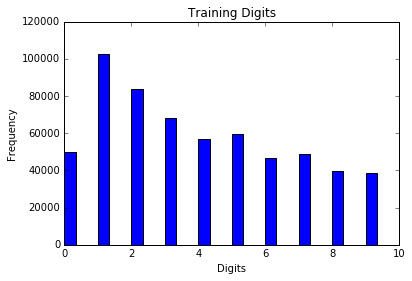

[ 0.07002605  0.18883991  0.14496092  0.11380485  0.10458826  0.09236626
  0.07974354  0.07643759  0.06481667  0.06441595]


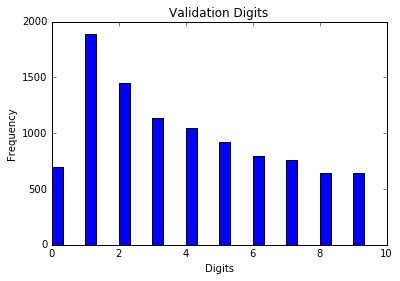

[ 0.06699447  0.1958743   0.15938076  0.1107099   0.09691918  0.09157959
  0.07594499  0.07755839  0.06376767  0.06127074]


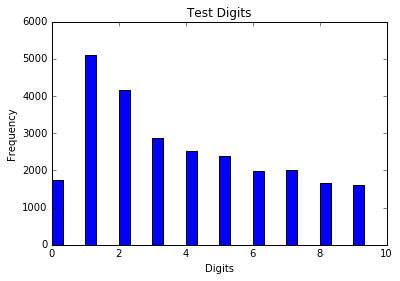

In [77]:
plot_label_distribution(train_labels, 'Training Digits')
plot_label_distribution(valid_labels, 'Validation Digits')
plot_label_distribution(test_labels, 'Test Digits')


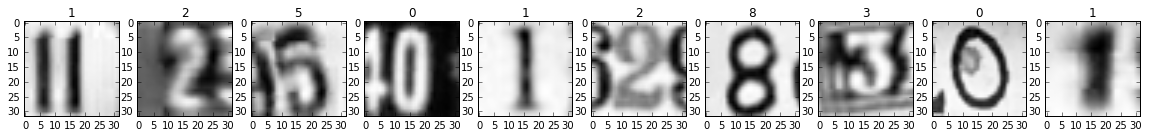

In [35]:
## display some images from the train set
display_size = 10
rand_indices = np.random.randint(0, train_images.shape[0], display_size)

fig = P.figure(figsize=(20, 20))
for idx in range(trial_set.shape[0]):
    a=fig.add_subplot(1,display_size,idx+1)
    P.imshow(train_images[rand_indices[idx],:,:, 0], cmap='Greys_r')  ## note that the image id has moved to leftmost
    a.set_title(str(train_labels[rand_indices[idx]]))

In [9]:
## always start a model with what you are going to measure it by
def accuracy(predictions, labels):
  assert(predictions.shape[0] == len(labels))
  return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

In [10]:
## prepare the tf graph

batch_size = 16
keep_prob_dropout = .95

## we have images of batch_size x 32 x 32 x 1
image_size = 32
image_initial_depth  = 1
num_channels = 1

## we will extract 5x5 patches at each stage
patch_size = 5
depth = 16

## num of nodes in the hidden layer (fully connected neural network)
num_hidden = 64


## create a graph
graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size))
  tf_valid_dataset = tf.constant(valid_images)
  tf_test_dataset = tf.constant(test_images)
  
  # Variables that will be optimised using backprop
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)) ## 5 x 5 x 1 x 16 -> 28 x 28 x 1 x 16
  layer1_biases = tf.Variable(tf.zeros([depth]))

  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.12))       ## 5 x 5 x 16 x 16 -> 24 x 24 x 16 x 16
  layer2_biases = tf.Variable(tf.zeros([depth]))

  ## Hidden Layer
  layer3_weights = tf.Variable(tf.truncated_normal(
      #[image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)) 
    [patch_size * patch_size * depth, num_hidden], stddev=0.12)) 
  layer3_biases = tf.Variable(tf.zeros([num_hidden]))
  #layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  ## Projection Layer
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.12))
  layer4_biases = tf.Variable(tf.constant(0.01, shape=[num_labels]))
  
  # Model.
  def model(data, is_training = False):
    """
        The model is as follows 
        
        Input -> Conv
        Conv -> Pooling
        Pooling -> ReLU
        ReLU -> Conv
        Conv -> Pooling
        Pooling -> ReLU
        
        At this stage, we will move to a fully connected neural net
        1 hidden layer followed by a projection layer and softmax (output)
        
    """
    
    # conv the first layer
    #conv0 = tf.nn.conv2d(data, layer0_weights, [1, 1, 1, 1], padding='VALID')

    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.avg_pool(conv, [1, 4, 4, 1], [1,2,2,1], padding = 'SAME')
    #conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    #pool = tf.nn.avg_pool(conv, [1, 4, 4, 1], [1,2,2,1], padding = 'VALID')
    hidden = tf.nn.relu(pool + layer1_biases)
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='VALID')
    pool = tf.nn.max_pool(conv, [1,1,1,1], [1,1,1,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    ## apply dropout
    if is_training:
        hidden  = tf.nn.dropout(hidden, keep_prob=keep_prob_dropout)
        
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset, True)
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
    
  # params for exponential_decay API
  # https://www.tensorflow.org/versions/r0.7/api_docs/python/train.html#exponential_decay
  # values for learning_rate [0.05, 0.15, 0.2, 0.25, 0.5]

  learning_rate = tf.train.exponential_decay(0.15, global_step, 1000, 0.95)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_images[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  final_predictions = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(final_predictions, test_labels))

Initialized
Minibatch loss at step 0: 2.406237
Minibatch accuracy: 18.8%
Validation accuracy: 10.5%
Minibatch loss at step 2500: 0.346792
Minibatch accuracy: 87.5%
Validation accuracy: 74.7%
Minibatch loss at step 5000: 0.786406
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 7500: 0.728756
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 10000: 0.237022
Minibatch accuracy: 93.8%
Validation accuracy: 83.8%
Minibatch loss at step 12500: 1.429365
Minibatch accuracy: 81.2%
Validation accuracy: 82.7%
Minibatch loss at step 15000: 0.306451
Minibatch accuracy: 93.8%
Validation accuracy: 84.9%
Minibatch loss at step 17500: 0.479263
Minibatch accuracy: 81.2%
Validation accuracy: 85.7%
Minibatch loss at step 20000: 0.191552
Minibatch accuracy: 93.8%
Validation accuracy: 86.6%
Minibatch loss at step 22500: 0.431889
Minibatch accuracy: 87.5%
Validation accuracy: 86.6%
Minibatch loss at step 25000: 0.155853
Minibatch accuracy: 93.8%
Validation

## Deeper

Now, we attempt to go deeper. The changes are as follows 

- Instead of a depth of 16, we will now reach a depth of 32 in the last layer
- We use the xavier initialization for conv2d for the conv matrices
- Since we now have our GPU working fine again, we use a batch size of 64 to speed up the process
- We decrease the dropout since we are increasing the number of epochs 4 times


In [17]:
batch_size = 64
keep_prob_dropout = 0.99

# start with
image_size = 32
num_channels = 1

# convolve layers
patch_size = 5
depth1 = 16
depth2 = 32

## FCN
num_hidden = 64
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size))
  tf_valid_dataset = tf.constant(valid_images)
  tf_test_dataset = tf.constant(test_images)
  
  # Variables.
  layer1_weights = tf.get_variable("conv1",
                                   shape = [patch_size, patch_size, num_channels, depth1],
                                   initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                  )
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  

  layer2_weights = tf.get_variable("conv2",
                                   shape = [patch_size, patch_size, depth1, depth2],
                                   initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                  )
  layer2_biases = tf.Variable(tf.zeros([depth2]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      #[image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)) 
    [patch_size * patch_size * depth2, num_hidden], stddev=0.1)) 
  layer3_biases = tf.Variable(tf.zeros([num_hidden]))

  ## create 5 predictors here for the five places
  
  op_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  # Model.
  def model(data, is_training = False):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID') # -> 28x28x1x16
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1,2,2,1], padding = 'SAME') ## 
    hidden = tf.nn.relu(pool + layer1_biases)
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    if is_training:
        hidden  = tf.nn.dropout(hidden, keep_prob=keep_prob_dropout)

    op = tf.matmul(hidden, op_weights) + op_biases
    return op

  logits = model(tf_train_dataset, True)
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
    
  # params for exponential_decay API
  # https://www.tensorflow.org/versions/r0.7/api_docs/python/train.html#exponential_decay
  # values for learning_rate [0.05, 0.15, 0.2, 0.25, 0.5]

  learning_rate = tf.train.exponential_decay(0.15, global_step, 1000, 0.95)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [19]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  ## initialize all variables
  tf.initialize_all_variables().run()
  print('Initialized')

  ## run the session
  for step in range(num_steps):
    
    # select the images to be used in this batch
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_images[offset:(offset + batch_size), :, :, :]
    
    ## pick the corresponding labels
    batch_labels = train_labels[offset:(offset + batch_size)]
    
    ## set them in the feed dict
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    ## run the ession
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    ## print some reports periodically to track the progress
    if (step % 2500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))

  ## now the model is trained. calculate final results
  final_predictions = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(final_predictions, test_labels))

Initialized
Minibatch loss at step 0: 2.342284
Minibatch accuracy: 6.2%
Validation accuracy: 15.5%
Minibatch loss at step 2500: 0.142237
Minibatch accuracy: 96.9%
Validation accuracy: 88.7%
Minibatch loss at step 5000: 0.124141
Minibatch accuracy: 95.3%
Validation accuracy: 90.0%
Minibatch loss at step 7500: 0.204740
Minibatch accuracy: 92.2%
Validation accuracy: 91.1%
Minibatch loss at step 10000: 0.259950
Minibatch accuracy: 92.2%
Validation accuracy: 91.9%
Minibatch loss at step 12500: 0.164970
Minibatch accuracy: 95.3%
Validation accuracy: 92.6%
Minibatch loss at step 15000: 0.101304
Minibatch accuracy: 95.3%
Validation accuracy: 92.5%
Minibatch loss at step 17500: 0.114144
Minibatch accuracy: 95.3%
Validation accuracy: 92.7%
Minibatch loss at step 20000: 0.114316
Minibatch accuracy: 95.3%
Validation accuracy: 93.0%
Minibatch loss at step 22500: 0.040853
Minibatch accuracy: 98.4%
Validation accuracy: 93.0%
Minibatch loss at step 25000: 0.176535
Minibatch accuracy: 98.4%
Validation 

In [37]:
## Hurray. We have gone up to 94! Time to stop the press!
## Or at least to update the report.

## calculate f1 score on this data
from sklearn.metrics import f1_score

print test_labels.shape
print final_predictions.shape

## convert final predictions to argmax-ed predictions (labels)

predicted_labels = np.argmax(final_predictions, axis=1)
print predicted_labels.shape

(26032,)
(26032, 10)
(26032,)


In [31]:
f1_weighted = f1_score(test_labels, predicted_labels, range(10), average='weighted')
f1_macro = f1_score(test_labels, predicted_labels, range(10), average='macro')
f1_micro = f1_score(test_labels, predicted_labels, range(10), average='micro')
f1_detailed = f1_score(test_labels, predicted_labels, range(10), average=None)

print "Weighted f1 score across all classes: {}".format(f1_weighted)
print '-'*80
print "Macro (unweighted) f1 score across all classes: {}".format(f1_macro)
print '-'*80
print "Micro f1 score across all classes: {}".format(f1_micro)
print '-'*80
print "Detailed F1 score across all classes"
for k,v in zip(range(10), f1_detailed):
    print "\tDigit: {}, F1 score: {}".format(k, v)

Weighted f1 score across all classes: 0.939635150424
--------------------------------------------------------------------------------
Macro (unweighted) f1 score across all classes: 0.935047394066
--------------------------------------------------------------------------------
Micro f1 score across all classes: 0.939651198525
--------------------------------------------------------------------------------
Detailed F1 score across all classes
	Digit: 0, F1 score: 0.933782267116
	Digit: 1, F1 score: 0.953611274222
	Digit: 2, F1 score: 0.958076597801
	Digit: 3, F1 score: 0.92217630854
	Digit: 4, F1 score: 0.950553797468
	Digit: 5, F1 score: 0.93567498942
	Digit: 6, F1 score: 0.92574880443
	Digit: 7, F1 score: 0.94088301322
	Digit: 8, F1 score: 0.912128712871
	Digit: 9, F1 score: 0.91783817557


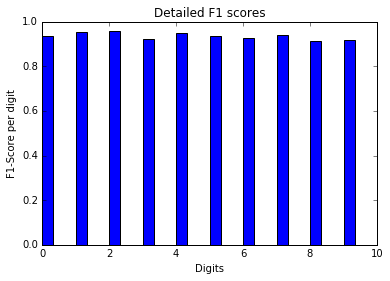

In [78]:
## plot the f1 scores for the various digits
plot_label_data(labels, f1_detailed, 'Detailed F1 scores', 'Digits', 'F1-Score per digit')